# setting the model

## parameter

In [1]:
# optimal model for analyzing scaled load
# setting up the model
from pyomo.environ import *
import pandas as pd
import time
import json
import random

big_M = 1e6
gas_price_value = 0.287               # price for gas, /MWh
gas_carbon = 0.4                      # gas carbon emission coefficient, unit: tons/MWh
carbon_emission_rate = 0.5366         # grid carbon emission coefficient, unit: tons/MWh

discount_rate = 0.06                  # discount rate

pv_rate = {1: 674.294, 2: 586.419, 3: 579.049, 4: 683.491}  # maximum photovoltaic generation per square kilometer for each city, unit: MW
sc_rate = {1: 3371.47, 2: 2932.09, 3: 2895.25, 4: 3417.45}  # maximum solar thermal generation per square kilometer for each city, unit: MW

#-----------------------------------------------------
# Device class definitions
# Photovoltaic/Solar thermal devices
class solar_device:
    def __init__(self, label, efficiency, output_kind, cost, area_rate):
        self.label = label              # device name
        self.efficiency = efficiency    # list, representing the efficiency of outputs for different energy types
        self.output_kind = output_kind  # list, representing the output energy types
        self.cost = cost                # construction cost per unit input capacity
        self.area_rate = area_rate      # generation/thermal output per unit area, unit: MW/m^2
        pass

# Energy conversion devices
class conversion_device:
    # Energy conversion device
    def __init__(self, label, efficiency, input_kind, output_kind, cost):
        # Record basic information about the device
        self.label = label              # device name
        self.efficiency = efficiency    # list, representing the efficiency of outputs for different energy types
        self.input_kind = input_kind    # string, representing the input energy type (currently supports single input type only)
        self.output_kind = output_kind  # list, representing the output energy types
        self.cost = cost                # construction cost per unit input capacity
        pass

class storage_device:
    # Energy storage device
    def __init__(self, label, input_efficiency, output_efficiency, input_kind,\
        output_kind, cost, self_discharge_rate, t_duration):
        self.label = label                          # device name
        self.input_efficiency = input_efficiency    # input efficiency
        self.output_efficiency = output_efficiency  # output efficiency
        self.input_kind = input_kind                # string, representing the input energy type
        self.output_kind = output_kind              # string, representing the output energy type
        self.cost = cost                            # construction cost per unit storage capacity
        self.self_discharge_rate = self_discharge_rate  # self-discharge rate
        self.t_duration = t_duration                # duration of the storage device cycle
        pass



## read and process data

In [ ]:
# read and process the data
#-----------------------------------------------------
def load_scaling(load, scale):
    load_scaled = [i * (1 + scale / 100) for i in load]
    return load_scaled

def read_data(city_code, load, scale):
    # Select the corresponding file name based on the input city code
    city_map = {
        1: "Beijing",
        3: "Wuhan",
        4: "Urumqi"
    }

    # Data file path
    file_path = './data/all_data.json'
    data = json.load(open(file_path, 'r'))
    # Read data
    elec_load = data[city_map[city_code]]["elec"]
    heat_load = data[city_map[city_code]]["heat"]
    cold_load = data[city_map[city_code]]["cool"]
    # uniform distribution as disturbance for Wuhan
    elec_factor = [random.uniform(0.8, 1.2) for _ in range(8760)]
    # Scale the data
    elec_load = [elec_load[i] * elec_factor[i] for i in range(8760)]

    elec_price = data['elec_price']
    gas_price = [gas_price_value for _ in range(8760)]
    pv_I = data[city_map[city_code]]["pv"]
    elec_carbon = [carbon_emission_rate for _ in range(8760)]
    # Scale the data
    if load =='elec':
        elec_load = load_scaling(elec_load, scale)
    elif load == 'heat':
        heat_load = load_scaling(heat_load, scale)
    elif load == 'cool':
        cold_load = load_scaling(cold_load, scale)
    elif load == 'all':
        heat_load = load_scaling(heat_load, scale)
        cold_load = load_scaling(cold_load, scale)
    else:
        pass
    return elec_load, heat_load, cold_load, elec_price, gas_price , pv_I, elec_carbon

## optimization

In [ ]:
# optimization function
# cost distbuted yearly
def old_equal(cost, year):
    return discount_rate/(1 - (1 + discount_rate) ** (-year))*cost

def optimal_plan(city_code, carbon_price, pv_space, load, scale):
    start_time = time.time()
    print('Modeling...')
    #-----------------------------------------------------

    m = ConcreteModel()
    #-----------------------------------------------------
    elec_load, heat_load, cold_load, elec_price, gas_price, pv_I, elec_carbon = read_data(city_code, load, scale)
    m.elec_load = elec_load
    m.heat_load = heat_load
    m.cold_load = cold_load
    m.pv_I = pv_I                   #normalization
    
    m.elec_price = elec_price
    m.gas_price = gas_price
    
    m.elec_carbon = elec_carbon     # the carbon factor propotional to normalized electricity load
    
    m.carbon_price = carbon_price   # price of carbon emission Wrmb/ton
    
    m.pv_space = pv_space           # the space of solar device installation
    
    # 所有待规划设备的字典
    # 光伏发电/太阳能集热器
    pv = solar_device(label = "PV", efficiency=[0.85], output_kind = ["elec"], cost = old_equal(689835, 25), area_rate = 100)
    sc = solar_device(label = "SC", efficiency=[0.75], output_kind = ["heat"], cost = old_equal(131400, 20), area_rate = 500)
    m.solar_device_list = [pv, sc]
    
    # 各能量转换设备信息录入
    heat_elec_collab = conversion_device(label = "CHP", efficiency=[0.3, 0.65], \
                                        input_kind = "gas", output_kind = ["elec", "heat"], cost = old_equal(773.07, 30))

    elec_boiler = conversion_device(label = "Electric_Boiler", efficiency=[0.85], \
                                        input_kind = "elec", output_kind = ["heat"], cost = old_equal(55.48, 20))
    
    compress_cold = conversion_device(label = "CERG", efficiency=[3.5], \
                                        input_kind = "elec", output_kind = ["cold"], cost = old_equal(123.37, 15))
    
    absorb_cold = conversion_device(label = "WARP", efficiency=[1.2], \
                                        input_kind = "heat", output_kind = ["cold"], cost = old_equal(86.14, 20))
    
    gas_boilder = conversion_device(label = "Gas_Boiler", efficiency=[0.85], \
                                        input_kind = "gas", output_kind = ["heat"], cost = old_equal(44, 20))
    
    Ground_source_heat_pump_heat = conversion_device(label = "Ground_Heat_Pump_heat", efficiency=[3.4], \
                                        input_kind = "elec", output_kind = ["heat"], cost = old_equal(330, 20))
    Ground_source_heat_pump_cold = conversion_device(label = "Ground_Heat_Pump_cold", efficiency=[4.6], \
                                        input_kind = "elec", output_kind = ["cold"], cost = 0)
    
    m.conversion_device_list = [heat_elec_collab, elec_boiler,compress_cold,\
                            absorb_cold, gas_boilder, Ground_source_heat_pump_heat,\
                            Ground_source_heat_pump_cold]
    
    #storage devices
    elec_storage = storage_device(label = "Elec_Storage", input_efficiency = 0.9539, output_efficiency = 0.9539, \
                                input_kind = "elec", output_kind = "elec", cost = old_equal(228, 10), self_discharge_rate = 0.00054, t_duration = 2)
    heat_storage = storage_device(label = "Heat_Storage", input_efficiency = 0.894, output_efficiency = 0.894, \
                                input_kind = "heat", output_kind = "heat", cost = old_equal(11, 20), self_discharge_rate = 0.0075,  t_duration = 5)
    cold_storage = storage_device(label = "Cold_Storage", input_efficiency = 0.894, output_efficiency = 0.894, \
                                input_kind = "cold", output_kind = "cold", cost = old_equal(11, 20), self_discharge_rate = 0.0075,  t_duration = 5)
    Seasonal_Heat_Storage = storage_device(label = "Seasonal_Heat_Storage", input_efficiency = 1, output_efficiency = 1, \
                                input_kind = "heat", output_kind = "heat", cost = old_equal(1.1325, 20),  self_discharge_rate = 0, t_duration = 1)
    
    m.storage_device_list = [elec_storage, heat_storage, cold_storage, Seasonal_Heat_Storage]
    
    #-------------------------------------------------------------------
    #defined time sets
    m.t_8760 = Set(initialize = [i for i in range(8760)])
    m.day_364 = Set(initialize = [i for i in range(364)])
    #----------------------------------------
    
    # index sets for conversion and storage devices
    converter_power_index = []
    for device in m.conversion_device_list:
        # input_kind
        device_kind_name = device.label + "_" + device.input_kind
        converter_power_index.append(device_kind_name)
        # output_kind
        for output_kind in device.output_kind:
            device_kind_name = device.label + "_" + output_kind
            converter_power_index.append(device_kind_name)
    
    m.set_converter_power = Set(initialize = converter_power_index)
    m.set_converter = Set(initialize = range(len(m.conversion_device_list)))
    m.set_storage = Set(initialize = range(len(m.storage_device_list)))

    #----------------------------------------
    #converter constrain
    m.convert_invest = Var(m.set_converter, within = NonNegativeReals)
    m.convert_power = Var(m.set_converter_power, m.t_8760, within = NonNegativeReals)


    for device in m.conversion_device_list:
        for output in device.output_kind:
            i = device.output_kind.index(output)
            fun_name = "c_{}_{}".format(device.label, output)
            input_kind = device.label + "_" + device.input_kind
            output_kind = device.label + "_" + output
            code_str = f'def {fun_name}(model, t):\n\t' \
                    f'return {device.efficiency[i]} * model.convert_power["{input_kind}",  t] == model.convert_power["{output_kind}", t]'
            
            local_env = {'m': m}
            exec(code_str, globals(), local_env)
            exec(f"m.constraint_{fun_name} = Constraint(m.t_8760, rule={fun_name})", globals(), local_env)
    
    #investment constraints for conversion devices
    def c_max_converter_input(model, device_id, t):
        m = model
        the_device = m.conversion_device_list[device_id]
        input_key = the_device.label + "_" + the_device.input_kind
        
        return m.convert_power[input_key, t] <= m.convert_invest[device_id]
    m.c_max_converter_input = Constraint(m.set_converter, m.t_8760, rule=c_max_converter_input)
    
    #----------------------------------------
    # binary variables for STES usage
    m.seasonal_heat_storage_used = Var(within=Binary)

    # binary variables for ground source heat pump
    m.Ground_source_heat_pump_heat_flag = Var(m.t_8760, within=Binary)
    m.Ground_source_heat_pump_cold_flag = Var(m.t_8760, within=Binary)
    
    # TODO: set the seasonal heat storage charging and discharging time, change with month
    
    
    
    # heat_pump capacity constraints
    def c_Ground_source_heat_pump(model):
        m = model
        Ground_heat_pump_heat_index = next(i for i, device in enumerate(m.conversion_device_list) if device.label == "Ground_Heat_Pump_heat")
        Ground_heat_pump_cold_index = next(i for i, device in enumerate(m.conversion_device_list) if device.label == "Ground_Heat_Pump_cold")
        return m.convert_invest[Ground_heat_pump_heat_index] == m.convert_invest[Ground_heat_pump_cold_index]
    m.c_Ground_source_heat_pump = Constraint(rule=c_Ground_source_heat_pump)
        
    def c_Ground_source_heat_pump_heat_input(model, t):
        m = model
        return m.convert_power["Ground_Heat_Pump_heat_elec", t] <= m.Ground_source_heat_pump_heat_flag[t] * big_M
    m.c_Ground_source_heat_pump_input = Constraint(m.t_8760, rule=c_Ground_source_heat_pump_heat_input)
    
    def c_Ground_source_heat_pump_cold_input(model, t):
        m = model
        return m.convert_power["Ground_Heat_Pump_cold_elec", t] <= m.Ground_source_heat_pump_cold_flag[t] * big_M
    m.c_Ground_source_heat_pump_output = Constraint(m.t_8760, rule=c_Ground_source_heat_pump_cold_input)
    
    def c_Ground_source_heat_pump_mutual_exclusive(model, t):
        m = model
        return m.Ground_source_heat_pump_heat_flag[t] + m.Ground_source_heat_pump_cold_flag[t] <= 1
    m.c_Ground_source_heat_pump_mutual_exclusive = Constraint(m.t_8760, rule=c_Ground_source_heat_pump_mutual_exclusive)

#----------------------------------------
    m.storage_invest = Var(m.set_storage, within = NonNegativeReals)
    m.storage_charge_power = Var(m.set_storage,  m.t_8760, within = NonNegativeReals)
    m.storage_discharge_power = Var(m.set_storage,  m.t_8760, within = NonNegativeReals)
    m.storage_soc = Var(m.set_storage, m.t_8760, within = NonNegativeReals)

    # STES connection with heat pump
    m.seasonal_heat_storage_heating = Var(m.t_8760, within = NonNegativeReals)
    
    # cooling
    def c_seasonal_heat_storage_input(model, t):
        m = model
        seasonal_heat_storage_index = next(i for i, device in enumerate(m.storage_device_list) if device.label == "Seasonal_Heat_Storage")
        return m.storage_charge_power[seasonal_heat_storage_index, t] == (4.6 + 1) * m.convert_power["Ground_Heat_Pump_cold_elec", t] 
    m.c_seasonal_heat_storage_input = Constraint(m.t_8760, rule=c_seasonal_heat_storage_input)

    # heating
    def c_seasonal_heat_storage_output(model, t):
        m = model
        seasonal_heat_storage_index = next(i for i, device in enumerate(m.storage_device_list) if device.label == "Seasonal_Heat_Storage")
        return m.storage_discharge_power[seasonal_heat_storage_index, t] == (3.4 - 1) * m.convert_power["Ground_Heat_Pump_heat_elec", t]
    m.c_seasonal_heat_storage_output = Constraint(m.t_8760, rule=c_seasonal_heat_storage_output)

    # storage transfer constraints
    def c_storage_transfer(model, storage_id, t):
        m = model
        the_device = m.storage_device_list[storage_id]
        
        if the_device.label == "Seasonal_Heat_Storage":
            if t == 0:
                return m.storage_soc[storage_id, 0] == m.storage_soc[storage_id, 8759] * (1 - the_device.self_discharge_rate)  \
                    + m.storage_charge_power[storage_id, 0] * the_device.input_efficiency \
                    - m.storage_discharge_power[storage_id, 0] / the_device.output_efficiency \
                    + m.seasonal_heat_storage_heating[0]
            else:
                return m.storage_soc[storage_id, t] == m.storage_soc[storage_id, t-1] * (1 - the_device.self_discharge_rate) \
                    + m.storage_charge_power[storage_id, t] * the_device.input_efficiency \
                    - m.storage_discharge_power[storage_id, t] / the_device.output_efficiency \
                    + m.seasonal_heat_storage_heating[t]
        else:
            if t == 0:
                return m.storage_soc[storage_id, 0] == m.storage_soc[storage_id, 8759] * (1 - the_device.self_discharge_rate)  \
                    + m.storage_charge_power[storage_id, 0] * the_device.input_efficiency \
                    - m.storage_discharge_power[storage_id, 0] / the_device.output_efficiency 
            else:
                return m.storage_soc[storage_id, t] == m.storage_soc[storage_id, t-1] * (1 - the_device.self_discharge_rate) \
                    + m.storage_charge_power[storage_id, t] * the_device.input_efficiency \
                    - m.storage_discharge_power[storage_id, t] / the_device.output_efficiency 
    m.c_storage_transfer = Constraint(m.set_storage, m.t_8760, rule = c_storage_transfer)
    
    def c_storage_daily_cycle(model, storage_id, day):
        m = model
        the_device = m.storage_device_list[storage_id]
        if the_device.label == "Seasonal_Heat_Storage":
            return Constraint.Skip
        else:
            return m.storage_soc[storage_id, day * 24] == m.storage_soc[storage_id, (day + 1) * 24]
    m.c_storage_daily_cycle = Constraint(m.set_storage, m.day_364, rule = c_storage_daily_cycle)

    def c_max_storage_input(model, storage_id, t):
        m = model
        the_device = m.storage_device_list[storage_id]

        if the_device.label == "Seasonal_Heat_Storage":
            return Constraint.Skip
        else:
            return m.storage_charge_power[storage_id, t] <= m.storage_invest[storage_id] / the_device.t_duration
    m.c_max_storage_input = Constraint(m.set_storage, m.t_8760, rule=c_max_storage_input) 
    
    
    def c_max_storage_output(model, storage_id,  t):
        m = model
        the_device = m.storage_device_list[storage_id]

        if the_device.label == "Seasonal_Heat_Storage":
            return Constraint.Skip
        else:
            return m.storage_discharge_power[storage_id, t] <= m.storage_invest[storage_id] / the_device.t_duration
    m.c_max_storage_output = Constraint(m.set_storage, m.t_8760, rule = c_max_storage_output)

    
    def c_max_storage_cap(model, storage_id,  t):
        m = model
        return m.storage_soc[storage_id, t] <= m.storage_invest[storage_id]
    m.c_max_storage_cap = Constraint(m.set_storage, m.t_8760, rule = c_max_storage_cap)
    
    def c_seasonal_heat_storage(model):
        m = model
        for storage_id, device in enumerate(m.storage_device_list):
            if device.label == "Seasonal_Heat_Storage":
                return m.storage_invest[storage_id] <= big_M * m.seasonal_heat_storage_used
        return Constraint.Skip
    m.c_seasonal_heat_storage = Constraint(rule=c_seasonal_heat_storage)

    #----------------------------------------
    m.solar_Area = Var(['pv', 'sc'], within=NonNegativeReals, initialize=0)
    def c_solar_invest(model):
        m = model
        return m.solar_Area['pv'] + m.solar_Area['sc'] <= m.pv_space
    m.c_solar_invest = Constraint(rule=c_solar_invest)
    
    # energy bus balance
    m.set_energy_kind = Set(initialize=["elec", "heat", "cold", "gas"])
    m.set_buy_energy = Set(initialize=["elec", "gas"])
    m.set_solar_energy = Set(initialize=["elec", "heat"])
    # electricity from grid
    m.buy_energy = Var(m.set_buy_energy, m.t_8760, within = NonNegativeReals)
    # solar energy production
    m.solar_energy = Var(m.set_solar_energy, m.t_8760, within=NonNegativeReals)
    def c_solar_energy_elec(model, t):
        m = model
        return m.solar_energy["elec", t] <= m.solar_Area['pv'] * m.pv_I[t] * pv_rate[city_code]

    def c_solar_energy_heat(model, t):
        m = model
        return m.solar_energy["heat", t] <= m.solar_Area['sc'] * m.pv_I[t] * sc_rate[city_code]

    m.c_solar_energy_elec = Constraint(m.t_8760, rule=c_solar_energy_elec)
    m.c_solar_energy_heat = Constraint(m.t_8760, rule=c_solar_energy_heat)

    def c_bus_balance(model, energy_kind, t):
        m = model
        total_output = 0
        if energy_kind == "elec" or energy_kind == "gas":
            total_output += m.buy_energy[energy_kind, t]
        if energy_kind == "elec":
            total_output += m.solar_energy["elec", t]
        elif energy_kind == "heat":
            total_output += m.solar_energy["heat", t]
        
        for device in m.conversion_device_list:
            if energy_kind == device.input_kind:
                input_key = device.label + "_" + energy_kind
                total_output -= m.convert_power[input_key, t]
            elif energy_kind in device.output_kind:
                output_key = device.label + "_" + energy_kind
                total_output += m.convert_power[output_key, t]
        
        for device_id in range(len(m.storage_device_list)):
            the_device = m.storage_device_list[device_id]
            if the_device.label == "Seasonal_Heat_Storage":
                continue
            if energy_kind == the_device.input_kind:
                total_output += m.storage_discharge_power[device_id, t] - m.storage_charge_power[device_id, t]
        
        if energy_kind == "elec":
            return total_output == m.elec_load[t]
        elif energy_kind == "heat":
            return total_output == m.heat_load[t] + m.seasonal_heat_storage_heating[t]
        elif energy_kind == "cold":
            return total_output == m.cold_load[t]
        elif energy_kind == "gas":
            return total_output == 0
        
    m.c_bus_balance = Constraint(m.set_energy_kind, m.t_8760, rule=c_bus_balance)
    #----------------------------------------
    # total cost
    m.total_cost = Var(within = NonNegativeReals)
    def c_objective(model):
        m = model
        #------------------------------------------------
        # investment cost
        m.invest_cost = 0
        for device_id in range(len(m.conversion_device_list)):
            the_device = m.conversion_device_list[device_id]
            m.invest_cost += the_device.cost * m.convert_invest[device_id]
        for device_id in range(len(m.storage_device_list)):
            the_device = m.storage_device_list[device_id]
            if the_device.label == "Seasonal_Heat_Storage":
                m.invest_cost += old_equal(116.32436, 20) * m.seasonal_heat_storage_used + the_device.cost * m.storage_invest[device_id]
            else:
                m.invest_cost += the_device.cost * m.storage_invest[device_id]
        m.invest_cost += pv.cost * m.solar_Area['pv']
        m.invest_cost += sc.cost * m.solar_Area['sc']
        #------------------------------------------------
        #operation cost
        m.oper_cost = 0
        m.carbon_cost = 0
        for t in m.t_8760:
            # unit as WRMB
            m.oper_cost += m.elec_price[t] * m.buy_energy["elec", t] / 10000
            m.oper_cost += m.gas_price[t] * m.buy_energy["gas", t] / 10000
            # carbin enmssion cost
            m.carbon_cost += m.carbon_price * m.elec_carbon[t] * m.buy_energy["elec", t] / 10000
            m.carbon_cost += m.carbon_price * gas_carbon * m.buy_energy["gas", t] / 10000

        # yearly cost
        return m.total_cost == m.invest_cost + m.oper_cost + m.carbon_cost
    m.c_objective = Constraint(rule = c_objective)
    #----------------------------------------
    m.objective = Objective(expr = m.total_cost, sense = minimize)

    #----------------------------------------
    print('Construction Complete. {}s used. Optimizing...'.format(time.time()-start_time))
    start_time = time.time()
    opt = SolverFactory('gurobi') 
    opt.solve(m)
    print('Optimization Complete. {}s used.'.format(time.time()-start_time))

    return m



# varying from 100-600

In [5]:
m100_beijing = optimal_plan(1, 100, 3.8, 'none', 0)
#m600_beijing = optimal_plan(1, 600, 3.8, 'none', 0)


Modeling...
Construction Complete. 25.635597229003906s used. Optimizing...

Interrupt request received


: 

In [9]:
def get_seasonal_heat_storage_capacity(m):
    for device in m.set_storage: 
        if m.storage_device_list[device].label == 'Seasonal_Heat_Storage':
            return m.storage_invest[device]()
    return 0
print('Seasonal Heat Storage Capacity:', get_seasonal_heat_storage_capacity(m600_wuhan))

Seasonal Heat Storage Capacity: 108.99520817029976


In [8]:
m100_wuhan = optimal_plan(3, 100, 3.8, 'none', 0)
m100_urumqi = optimal_plan(4, 100, 3.8, 'none', 0)
m200_beijing = optimal_plan(1, 200, 3.8, 'none', 0)
m200_wuhan = optimal_plan(3, 200, 3.8, 'none', 0)
m200_urumqi = optimal_plan(4, 200, 3.8, 'none', 0)
m300_beijing = optimal_plan(1, 300, 3.8, 'none', 0)
m300_wuhan = optimal_plan(3, 300, 3.8, 'none', 0)
m300_urumqi = optimal_plan(4, 300, 3.8, 'none', 0)
m400_beijing = optimal_plan(1, 400, 3.8, 'none', 0)
m400_wuhan = optimal_plan(3, 400, 3.8, 'none', 0)
m400_urumqi = optimal_plan(4, 400, 3.8, 'none', 0)
m500_beijing = optimal_plan(1, 500, 3.8, 'none', 0)
m500_wuhan = optimal_plan(3, 500, 3.8, 'none', 0) #卡在这里
m500_urumqi = optimal_plan(4, 500, 3.8, 'none', 0)
m600_wuhan = optimal_plan(3, 600, 3.8, 'none', 0)# 卡在这里
m600_urumqi = optimal_plan(4, 600, 3.8, 'none', 0)

Modeling...
Construction Complete. 2.7258989810943604s used. Optimizing...
Optimization Complete. 258.82265043258667s used.
Modeling...
Construction Complete. 3.742633819580078s used. Optimizing...
Optimization Complete. 130.03617548942566s used.
Modeling...
Construction Complete. 3.20806884765625s used. Optimizing...
Optimization Complete. 306.1076509952545s used.
Modeling...
Construction Complete. 3.4119296073913574s used. Optimizing...
Optimization Complete. 251.41313886642456s used.
Modeling...
Construction Complete. 2.23229718208313s used. Optimizing...
Optimization Complete. 294.9669671058655s used.
Modeling...
Construction Complete. 3.8218793869018555s used. Optimizing...
Optimization Complete. 225.59251284599304s used.
Modeling...
Construction Complete. 2.199859857559204s used. Optimizing...
Optimization Complete. 250.63774490356445s used.
Modeling...
Construction Complete. 2.217603921890259s used. Optimizing...
Optimization Complete. 234.1869740486145s used.
Modeling...
Constr

In [9]:
import os
import numpy as np
import pandas as pd

# Function to get seasonal heat storage capacity
def get_seasonal_heat_storage_capacity(m):
    for device in m.set_storage: 
        if m.storage_device_list[device].label == 'Seasonal_Heat_Storage':
            return m.storage_invest[device]()
    return 0

# Calculate STES capacities for each city
stes_capacity_beijing = [
    get_seasonal_heat_storage_capacity(m100_beijing),
    get_seasonal_heat_storage_capacity(m200_beijing),
    get_seasonal_heat_storage_capacity(m300_beijing),
    get_seasonal_heat_storage_capacity(m400_beijing),
    get_seasonal_heat_storage_capacity(m500_beijing),
    get_seasonal_heat_storage_capacity(m600_beijing)
]

stes_capacity_wuhan = [
    get_seasonal_heat_storage_capacity(m100_wuhan),
    get_seasonal_heat_storage_capacity(m200_wuhan),
    get_seasonal_heat_storage_capacity(m300_wuhan),
    get_seasonal_heat_storage_capacity(m400_wuhan),
    get_seasonal_heat_storage_capacity(m500_wuhan),
    get_seasonal_heat_storage_capacity(m600_wuhan)
]

stes_capacity_urumqi = [
    get_seasonal_heat_storage_capacity(m100_urumqi),
    get_seasonal_heat_storage_capacity(m200_urumqi),
    get_seasonal_heat_storage_capacity(m300_urumqi),
    get_seasonal_heat_storage_capacity(m400_urumqi),
    get_seasonal_heat_storage_capacity(m500_urumqi),
    get_seasonal_heat_storage_capacity(m600_urumqi)
]

# Carbon prices
carbon_prices = [100, 200, 300, 400, 500, 600]

# Create a DataFrame to store the results
results = pd.DataFrame({
    'Carbon Price (RMB/tCO2)': carbon_prices,
    'Beijing STES Capacity (MWh)': stes_capacity_beijing,
    'Wuhan STES Capacity (MWh)': stes_capacity_wuhan,
    'Urumqi STES Capacity (MWh)': stes_capacity_urumqi
})

# Ensure the directory exists
output_dir = '/home/user/workspaces/CUE2025_final/carbon_results'
os.makedirs(output_dir, exist_ok=True)

# Save the results to a CSV file
output_file = os.path.join(output_dir, 'stes_capacity_results.csv')
results.to_csv(output_file, index=False)

print(f"Results have been saved to {output_file}")

Results have been saved to /home/user/workspaces/CUE2025_final/carbon_results/stes_capacity_results.csv


In [ ]:
#importstes_capacity_beijing，stes_capacity_wuhanstes_capacity_urumqi
import pandas as pd
data = pd.read_csv('/home/user/workspaces/CUE2025_final/carbon_results/stes_capacity_results.csv')
stes_capacity_beijing = data['Beijing STES Capacity (MWh)']
stes_capacity_wuhan = data['Wuhan STES Capacity (MWh)']
stes_capacity_urumqi = data['Urumqi STES Capacity (MWh)']

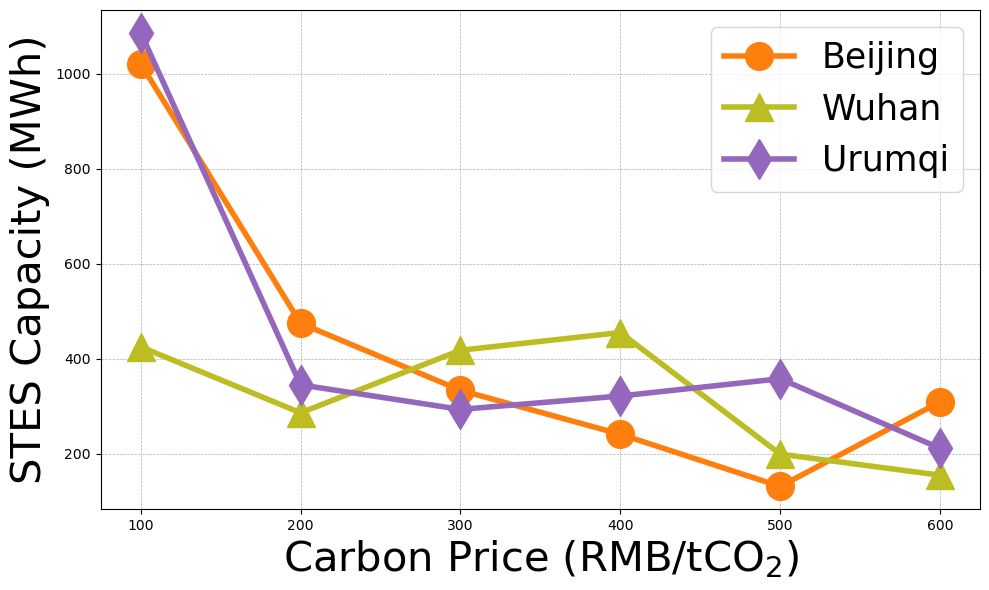

In [ ]:
# stes_capacity vs carbon price plot
import matplotlib.pyplot as plt

carbon_prices = [100, 200, 300, 400, 500, 600] 

plt.figure(figsize=(10, 6))
plt.plot(carbon_prices, stes_capacity_beijing, label='Beijing', marker='o', markersize=20, linewidth=4, color='tab:orange')
plt.plot(carbon_prices, stes_capacity_wuhan, label='Wuhan', marker='^', markersize=20, linewidth=4, color='tab:olive')
plt.plot(carbon_prices, stes_capacity_urumqi, label='Urumqi', marker='d', markersize=20, linewidth=4, color='tab:purple')

plt.xlabel('Carbon Price (RMB/tCO$_2$)', fontsize=30)
plt.ylabel('STES Capacity (MWh)', fontsize=30)

plt.legend(fontsize=25)

plt.grid(True, linestyle='--', linewidth=0.5)

plt.tight_layout()

plt.show()

# net demand compare

In [15]:
# save the data of heat demand and solar energy in 100 & 600 RMB/tCO2
import os
import pandas as pd

# Save the data of heat demand and solar energy at 100 & 600 RMB/tCO2
# Create a DataFrame for 100 RMB/tCO2
months = np.arange(1, 13)
data_100 = pd.DataFrame({
    'Month': months,
    'Heat Demand (100 RMB/tCO2)': beijing_heat_monthly,
    'Cool Demand (100 RMB/tCO2)': beijing_cool_monthly,
    'Electricity Demand (100 RMB/tCO2)': beijing_elec_monthly
})

# Create a DataFrame for 600 RMB/tCO2
data_600 = pd.DataFrame({
    'Month': months,
    'Heat Demand (600 RMB/tCO2)': beijing_heat_monthly2,
    'Cool Demand (600 RMB/tCO2)': beijing_cool_monthly2,
    'Electricity Demand (600 RMB/tCO2)': beijing_elec_monthly2
})

# Combine the two DataFrames
combined_data = pd.concat([data_100, data_600], axis=1)

# Ensure the directory exists
output_dir = '/home/user/workspaces/CUE2025_final/carbon_results'
os.makedirs(output_dir, exist_ok=True)

# Save the combined data to a CSV file
output_file = os.path.join(output_dir, 'heat_and_solar_demand_100_600.csv')
combined_data.to_csv(output_file, index=False)

print(f"Data has been saved to {output_file}")

Data has been saved to /home/user/workspaces/CUE2025_final/carbon_results/heat_and_solar_demand_100_600.csv


In [14]:
import numpy as np
import matplotlib.pyplot as plt

#计算热静负荷， 热负荷减去光热加上warp热转冷
m = m100_beijing
beijing_heat_demand = m.heat_load
beijing_heat_demand = [(beijing_heat_demand[t]  - m.solar_energy['heat', t]()) for t in m.t_8760]
beijing_cool_demand = m.cold_load
beijing_cool_demand = [(beijing_cool_demand[t] ) for t in m.t_8760]

beijing_elec_demand = m.elec_load
beijing_elec_demand = [(beijing_elec_demand[t] - m.solar_energy['elec', t]()) for t in m.t_8760]

# 计算月平均负荷
def calculate_monthly_average(demand):
    monthly_average = []
    for i in range(0, len(demand), 730):
        monthly_average.append(np.mean(demand[i:i+730]))
    return monthly_average

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
beijing_heat_monthly = calculate_monthly_average(beijing_heat_demand)
beijing_cool_monthly = calculate_monthly_average(beijing_cool_demand)
beijing_elec_monthly = calculate_monthly_average(beijing_elec_demand)
m = m600_beijing
beijing_heat_demand2 = m.heat_load
beijing_heat_demand2 = [(beijing_heat_demand[t]  - m.solar_energy['heat', t]()) for t in m.t_8760]
beijing_cool_demand2 = m.cold_load
beijing_cool_demand2 = [(beijing_cool_demand[t] ) for t in m.t_8760]

for t in m.t_8760:
    if beijing_cool_demand2[t] < 0:
        beijing_heat_demand2[t] = beijing_heat_demand2[t] + beijing_cool_demand2[t]
        beijing_cool_demand2[t] = 0

beijing_heat_monthly2 = calculate_monthly_average(beijing_heat_demand2)
beijing_cool_monthly2 = calculate_monthly_average(beijing_cool_demand2)
beijing_elec_monthly2 = calculate_monthly_average(beijing_elec_demand)

/tmp/ipykernel_76793/2331952895.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(ax1.get_yticks().astype(int), fontsize=30)  # 设置 y 轴刻度字体大小


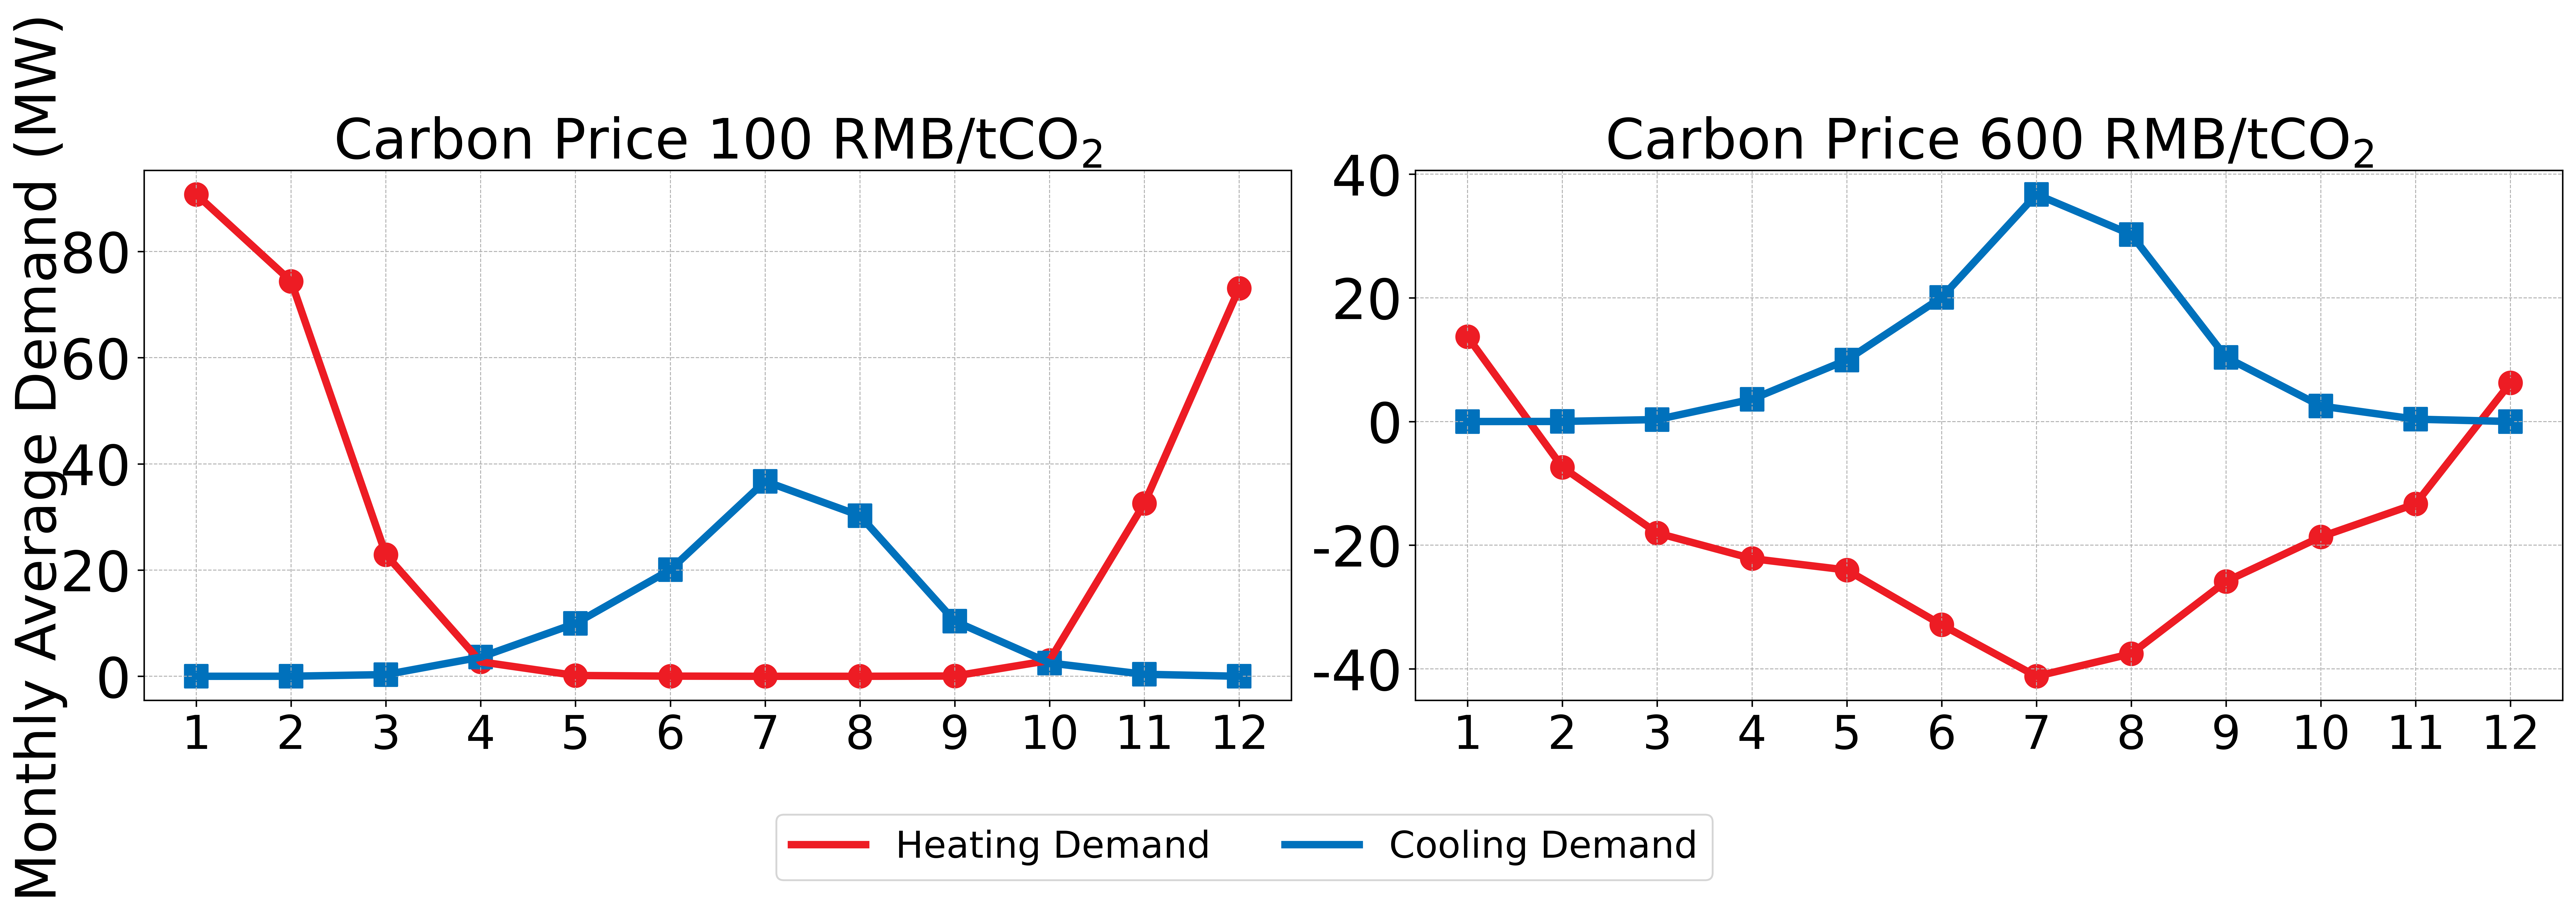

In [ ]:
#montly average heat and cool demand & net load
def plot_gradient_fill(ax, x, y, color, label, marker):
    ax.plot(x, y, color=color, linewidth=4, label=label)
    ax.scatter(x, y, color=color, s=150, marker=marker) 

month_numbers = np.arange(1, 13)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), dpi=600)

plot_gradient_fill(ax1, month_numbers, beijing_heat_monthly, '#ED1C24', 'Heating Demand', marker='o') 
plot_gradient_fill(ax1, month_numbers, beijing_cool_monthly, '#0071BC', 'Cooling Demand', marker='s') 
ax1.grid(True, linestyle='--', linewidth=0.5)
ax1.set_xticks(month_numbers)
ax1.set_xticklabels(months, fontsize=25)
ax1.set_yticklabels(ax1.get_yticks().astype(int), fontsize=30) 
ax1.set_title('Carbon Price 100 RMB/tCO$_2$', fontsize=30)

plot_gradient_fill(ax2, month_numbers, beijing_heat_monthly2, '#ED1C24', 'Heating Demand', marker='o')
plot_gradient_fill(ax2, month_numbers, beijing_cool_monthly2, '#0071BC', 'Cooling Demand', marker='s')
ax2.grid(True, linestyle='--', linewidth=0.5)
ax2.set_xticks(month_numbers)
ax2.set_xticklabels(months, fontsize=25)
ax2.set_yticks(range(int(min(min(beijing_heat_monthly2), min(beijing_cool_monthly2)))+1, int(max(max(beijing_heat_monthly2), max(beijing_cool_monthly2))) +1+ 20, 20))
ax2.set_yticklabels(ax2.get_yticks().astype(int), fontsize=30)  
ax2.set_title('Carbon Price 600 RMB/tCO$_2$', fontsize=30) 


fig.text(0.04, 0.5, 'Monthly Average Demand (MW)', va='center', rotation='vertical', fontsize=30)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2, fontsize=20)

plt.tight_layout(rect=[0.05, 0.1, 1, 0.95]) 


plt.show()
fig.savefig('/home/user/workspaces/CUE2025_final/carbon_results/heat_cool_demand.png', bbox_inches='tight')